# Biodiversity Intactness Index change in Phoenix subdivision

Let's load all the libraries in and import potential packages we would need for the biodiversity intactness. 

In [8]:
#read in two separate rasters
# import libraries and functions here
import numpy as np
import geopandas as gpd
import rioxarray as rioxr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from shapely.geometry import Polygon

# used to access STAC catalogs
from pystac_client import Client
# used to sign items from the MPC STAC catalog
import planetary_computer

# ----- other libraries for nice ouputs
from IPython.display import Image
import contextily as ctx #for adding basemaps

## Load Data

In [9]:
#load phoenix subdivision shape file data 
phoenix_sub = gpd.read_file("data/tl_2022_04_cousub")
#access catalog to load 2017 and 2020 data 
catalog = Client.open('https://planetarycomputer.microsoft.com/api/stac/v1',
                     modifier = planetary_computer.sign_inplace)
#access io biodiversity 
io_collection = catalog.get_child('io-biodiversity')


In [10]:
#define time range and bbox to pull 2017
time_range = "2017-01-01/2017-12-31"
bbox =  [-112.826843, 32.974108, -111.184387, 33.863574]

# catalog search
search = catalog.search(
    collections=['io-biodiversity'],
    bbox = bbox,
    datetime=time_range)

#define time range only to pul 2020(use the same bbox)
time_range1 = "2020-01-01/2020-12-31"
# catalog search
search2 = catalog.search(
    collections=['io-biodiversity'],
    bbox = bbox,
    datetime=time_range1)



In [11]:
#use items to call in catalog search 
items = search.item_collection()
items2 = search2.item_collection()

#get all the items of the catalog search
item = items[0]
item2 = items2[0]


## Convert data from MPC to raster data 

In [12]:
#turn into raster using rasterio for 2017 and show to check it worked 
mc = rioxr.open_rasterio(item.assets['data'].href)
#turn into raster using rasterio data for 2020 data 
mc2 = rioxr.open_rasterio(item2.assets['data'].href)

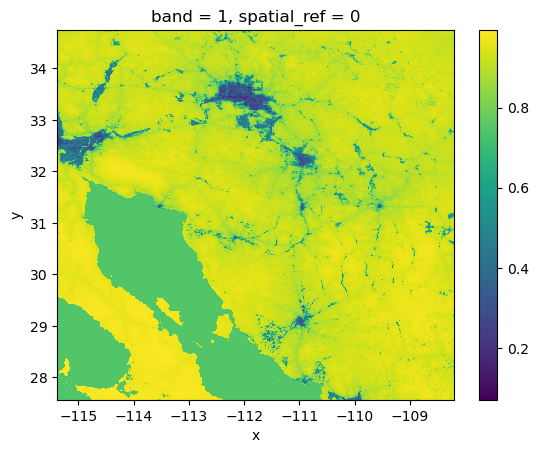

In [13]:
#plot ther spatial raster to see how it looks (loading this helps future functions load faster)
mc.plot()

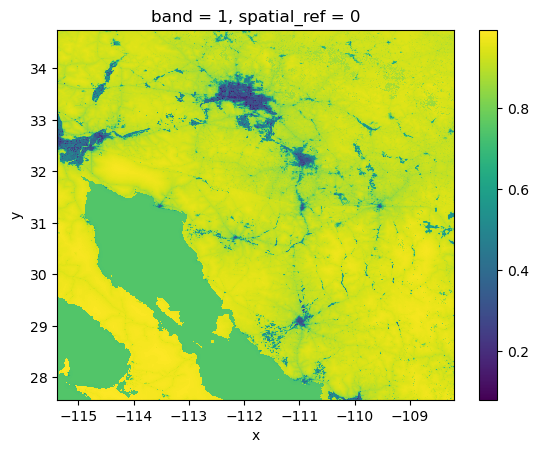

In [14]:
#plot the spatial raster to see how it looks (loading this helps future functions go quicker)
mc2.plot()

In [15]:
#filter for the phoenix dataset only 
maricopa = phoenix_sub[phoenix_sub.NAME == "Phoenix"]

## Plot the pheonix dataset w geographical context 

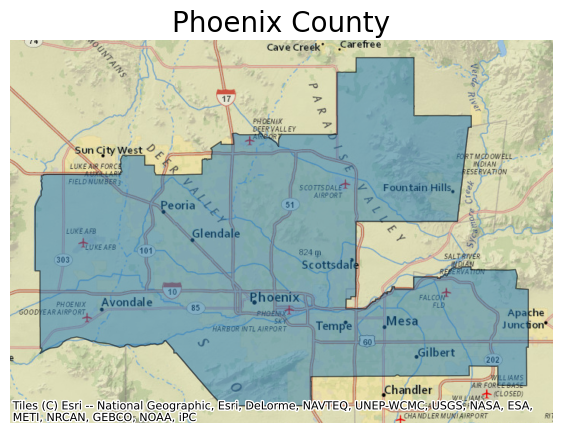

In [16]:
# create axis with plot
ax = (maricopa.to_crs(epsg=3857) #switch the crs 
      .plot(figsize=(7, 7), alpha=0.5, edgecolor="k")
      )

# add basemap from contextily 
ctx.add_basemap(ax, source=ctx.providers.Esri.NatGeoWorldMap)

# update axes
ax.set_title("Phoenix County", fontdict={"fontsize": "20"})
ax.set_axis_off()

## Clipping data for visualization 

In [17]:
#check the crs of each 
#mc.rio.crs == 4326

#change the maricopa crs 
maricopa.crs = "epsg:4326"
#check to make sure they match 
maricopa.crs == mc.rio.crs

#clip the data to match maricopa shape file 
clip_2017 = (mc.rio.clip(maricopa.geometry))
clip_2020 = (mc2.rio.clip(maricopa.geometry))


In [18]:
#adjust each of these to filter for BII index greater than .75 for 2017 
greater_data2017 = (clip_2017>=.75)
#convert to integar for calculations 
greater_int2017 = greater_data2017.astype(int)
#asjust each of these to filter for BII index greater than .75 for 2020 
greater_data2020 = (clip_2020>=.75)
#convert to integar for calculation 
greater_int2020 = greater_data2020.astype(int)


In [19]:
#find the percentage area for 2017
percent_area2017 = (greater_int2017.sum() / clip_2017.count())*100
#find percent area for 2020 
percent_area2020 = (greater_int2020.sum() / clip_2020.count())*100

print(percent_area2017)
print(percent_area2020)


<xarray.DataArray ()>
array(7.12518453)
Coordinates:
    spatial_ref  int64 0
<xarray.DataArray ()>
array(6.49129023)
Coordinates:
    spatial_ref  int64 0


**The percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2017 is 7.12%.**
**The percentage of area of the Phoenix subdivision with a BII of at least 0.75 in 2017 is 6.49%.**

In [20]:
#subtract the original raster datasets that are greater than .75 and subtract 
new = greater_int2017 - greater_int2020 #there was a loss of BII between 2017 and 2020 so we subtract 2017 - 2020 

In [21]:
# drop the band on the 'new' plot 
new1 = new.squeeze().drop('band')
#pick only values that are = 1 to plot 
new2 = new1.where(new1 == 1, np.nan)

## Visualization showing the area with BII>=0.75 in 2017 that was lost by 2020. 

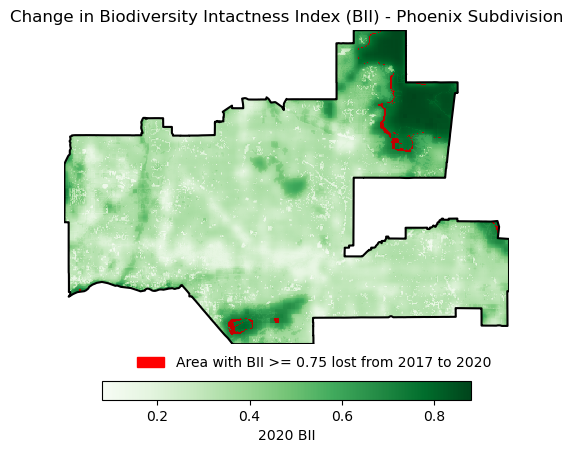

In [22]:
#create the figure 
fig, ax = plt.subplots()

#Plot first raster which is the 2020 clipped 
im = clip_2020.plot(ax = ax, cmap = "Greens", add_colorbar = False)
color_bar = plt.colorbar(im, ax = ax, orientation = 'horizontal', fraction = 0.05, pad = 0.1)
color_bar.set_label('2020 BII')

#rotate the colorbar label
#color_bar.ax.yaxis.label.set_rotation(270)

#Plot `new` plot to put over the clipped_2020 plot 
im1 = new2.plot(ax = ax, cmap = 'gist_heat', add_colorbar = False)

# Plot the shapefile underneath for the outline of the file 
maricopa.plot(ax=ax, color='none', edgecolor='black', linewidth=1.5)

#use mpatches to add the color bar for the area with greater/equal .75 
new_patch = mpatches.Patch(color = 'red', label = "Area with BII >= 0.75 lost from 2017 to 2020")

#do the legend 
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles = [new_patch], frameon = False, loc = (0.15, -0.1))
#set the title for the map 
ax.set_title('Change in Biodiversity Intactness Index (BII) - Phoenix Subdivision')
ax.axis('off')
#show the data 
plt.show()